# Randomized SVD 
## 核心
传统的 SVD 算法在数学上是完美的，但在工程上是“昂贵”的。对于一个 $m \times n$ 的庞大矩阵，如果我们要提取前 $k$ 个特征：
- 传统 SVD：必须处理整个矩阵，耗时极长。
- 随机 SVD：利用概率论的魔法。既然大矩阵通常只有少量的“主要成分”（低秩结构），我们可以通过“随机采样”快速抓住这些主要成分，忽略噪声。核心目标： 

找到一个低维的正交基矩阵 $Q$ (m x l) 而且 l<< n，使得矩阵 $A$ (m x n)投影到 $Q$ 上时，信息损失最小。
$$A \approx Q Q^T A$$

### 投影矩阵$Q$几何解释

场景：三维空间里的蝴蝶

想象矩阵 $A$ 是一只悬浮在 3D 空间里的蝴蝶。虽然它在 3D 空间里，但它的翅膀非常薄，本质上它几乎就是一个 2D 平面 物体。

- 寻找 $Q$ (寻找最佳角度)：我们的任务是找到一个平面 $Q$（比如地面），使得当我们把蝴蝶拍扁在地面上时，影子的面积最大，细节最全。
    - 如果 $Q$ 选得好（平行于翅膀），影子 $\approx$ 蝴蝶。
    - 这就是 $A \approx Q Q^T A$ 的含义。
- 降维 ($Q^T A$)：我们不再记录蝴蝶在空中的 $(x, y, z)$ 坐标，而是只记录它在地面上的影子坐标 $(u, v)$。这就把数据量从 3D 压缩到了 2D。
- 还原 ($Q \cdot (Q^T A)$)：如果我们想看回蝴蝶，我们就把地面的影子“贴”回 3D 空间的高度。这实际上是重构过程。
- 例子：
    - $A$（原始数据）： 坐标是 $(3, 4, 5)$。
    - $Q$（子空间）： 我们只关心地面（即 $X-Y$ 平面）。地面的基向量是 $X$轴 $[1, 0, 0]^T$ 和 $Y$轴 $[0, 1, 0]^T$。
    
    $$Q = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 0 & 0 \end{bmatrix}$$
    - $Q^T A$ — “降维测量” (Encoding)。 Z维度消失，压缩3D到2D
    $$\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \begin{bmatrix} 3 \\ 4 \\ 5 \end{bmatrix} = \begin{bmatrix} \mathbf{3} \\ \mathbf{4} \end{bmatrix}$$
    
    - $Q (Q^T A)$ —— “投影重构” (Decoding)。 现在，我们把刚才得到的 2D 坐标 $\begin{bmatrix} 3 \\ 4 \end{bmatrix}$ 再乘上 $Q$。$Q$ 的维度是 $(3 \times 2)$，它把 2D 的数据“放回”到 3D 空间里。
    
    $$\begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} 3 \\ 4 \end{bmatrix} = \begin{bmatrix} \mathbf{3} \\ \mathbf{4} \\ \mathbf{0} \end{bmatrix}$$
    - 解读：
         - 结果变回了 3D 向量 $\begin{bmatrix} 3 \\ 4 \\ 0 \end{bmatrix}$。
         - 物理意义： **“还原动作”——准确地说是“还原维度”**。它把那张写着 $(3, 4)$ 的二维数据，重新贴回到了三维。 $Q Q^T$ 效果就是把原始向量中垂直于 $Q$ 平面的分量（高度 5）给强行抹零了，只保留了平行于 $Q$ 平面的分量。


## 算法核心步骤与数学推导
rSVD 分为两个主要阶段：A阶段（寻找子空间） 和 B阶段（分解子空间）。
### 3.1 寻找子空间 range finder
#### 3.1.1 高斯随机投影 (Gaussian Projection)

我们需要一个“探测器”来探测 $A$ 的主要方向。生成一个 $n \times l$ 的高斯随机矩阵 $\Omega$（$l = k + \text{oversample}$）。计算：$$Y = A \Omega$$

- 直观解释: $Y$ 的每一列都是 $A$ 的列向量的随机线性组合。根据高维几何特性，这些随机组合大概率会指向 $A$ 的主要方向（大奇异值方向）。
- 数学作用：将输入空间从庞大的 $n$ 维压缩到了 $l$ 维。

#### 3.1.2 幂迭代 (Power Iteration)

如果矩阵 $A$ 的奇异值衰减很慢（主要信号和噪声差不多大），单次投影 $A \Omega$ 可能会混入太多噪声。我们需要一个“放大器”。计算：$$Y^{(q)} = (A A^T)^q A \Omega$$
- 直观解释：这不是投影，这是拉伸。$A A^T$ 的特征值是奇异值的平方 $\sigma^2$。每乘一次 $A A^T$，主要成分（大 $\sigma$）会被放大 $\sigma^2$ 倍，而噪声（小 $\sigma$）虽然也被放大，但倍数小得多。经过 $q$ 次迭代，主要成分呈现指数级增长，噪声相对“萎缩”。
- 数学推导：若 $A = U \Sigma V^T$，则 $(A A^T)^q A = U \Sigma^{2q+1} V^T$。权重从 $\Sigma^1$ 变成了 $\mathbf{\Sigma^{2q+1}}$。差异被剧烈拉大。


#### 3.1.3 正交化 (QR Decomposition)
为了数值稳定性，我们需要将 $Y$ 转化为标准正交基 $Q$。$$Y = Q R$$丢弃 $R$，保留 $Q$。此时 $Q$ 是一个 $m \times l$ 的矩阵，它的列向量张成的空间覆盖了 $A$ 的主要列空间。

### 3.2 子空间内的 SVD (Decomposition)
既然 $A$ 的精华已经被捕捉到了 $Q$ 这个小空间里，我们就不需要在这个大矩阵上做文章了。

#### 3.2.1 投影与压缩

将 $A$ 投影到 $Q$ 的坐标系中：$$B = Q^T A$$解释：这里就是求“影子坐标”。$B$ 的尺寸是 $(l \times n)$，其中 $l$ 很小。我们在一个小矩阵上工作。
- $Q^T$ 是 $(l \times m)$。
- $A$ 是 $(m \times n)$。
- $B$ 是 $(l \times n)$。

注意 $B$ 的形状。它的高度被压缩了（从 $m$ 变成了 $l$），但是它的宽度没有变（还是 $n$）

#### 3.2.2 标准 SVD

对小矩阵 $B$ 进行标准 SVD 分解（非常快）：$$B = \tilde{U} \Sigma V^T$$

- $V^T$（右奇异向量）：它是描述列空间的。因为 $B$ 的宽度是 $n$（和 $A$ 一样），所以算出来的 $V$ 的维度是 $(n \times n)$。它直接对应原始输入空间的维度！所以它不需要变，它就是我们最终想要的 $V$（或者说 $V$ 的最佳近似）。所以我们不加波浪号。
- $\tilde{U}$（左奇异向量）：它是描述行空间的（即 $B$ 的高度方向）。因为 $B$ 的高度只有 $l$，所以算出来的 $\tilde{U}$ 维度是 $(l \times l)$。但是！原始矩阵 $A$ 的左奇异向量 $U$ 应该是 $(m \times m)$ 的。$l$ 和 $m$ 差了十万八千里。所以这个 $\tilde{U}$ 只是一个在“小人国”里的左奇异向量，它不是最终的大 $U$。为了区分，我们给它加上 tilde（波浪号），表示它是“中间变量”。


#### 3.2.3 还原左奇异向量
刚才得到的 $\tilde{U}$ 是在 $Q$ 这个小空间里的方向。我们需要把它映射回原空间 $A$ 的维度：$$U = Q \tilde{U}$$
最终结果：$A \approx U \Sigma V^T$。

rSVD 的核心假设是：$$A \approx Q B$$

因为 $B = Q^T A$，且 $A \approx Q Q^T A$，代入即得 $A \approx Q B$。

现在，把 $B$ 的 SVD 公式 $B = \tilde{U} \Sigma V^T$ 代入上面的式子：$$A \approx Q (\tilde{U} \Sigma V^T)$$

根据矩阵乘法的结合律（括号随便加）：$$A \approx (Q \tilde{U}) \Sigma V^T$$

我们对比一下标准 SVD 的定义形式：$$A \approx U \Sigma V^T$$
对应一下位置：
- $\Sigma$ 对应 $\Sigma$$
- V^T$ 对应 $V^T$
- $U$ 对应 $(Q \tilde{U})$

所以：$$\mathbf{U = Q \tilde{U}}$$

维度检查（Double Check）：
- $Q$ 是 $(m \times l)$ （长条形，把 2D 映射回 3D）
- $\tilde{U}$ 是 $(l \times l)$ （小方块，2D 空间内部的旋转）
- 乘积 $Q \tilde{U}$ 的维度是 $(m \times l)$。这正是我们要的 $U$ 的形状（的前 $k$ 列，这里 $l \approx k$）。

总结
- $V$ 不带波浪号：因为 $B$ 保留了 $A$ 的全宽度 ($n$)，所以算出来的 $V$ 直接就是原空间里的 $V$。
- $\tilde{U}$ 带波浪号：因为 $B$ 的高度被 $Q$ 压缩了，算出来的 $\tilde{U}$ 是低维空间里的向量。
- $U = Q \tilde{U}$：这步操作叫**“升维”**


4. 流程总结图解

| 步骤 | 公式 | 物理含义 | 维度变化 (假设 A: 1000x1000, 找 k=10) |
| :--- | :--- | :--- | :--- |
| **1. 生成随机矩阵** | $\Omega$ | 制造探测器 | $1000 \times 20$ |
| **2. 随机采样** | $Y_0 = A\Omega$ | 初步压缩 | $1000 \times 20$ |
| **3. 幂迭代 (核心)** | $Y = (AA^T)^q Y_0$ | **信号放大/提纯** | $1000 \times 20$ |
| **4. 获取基 $Q$** | $Q, \_ = qr(Y)$ | 建立纯净坐标系 | $1000 \times 20$ |
| **5. 降维投影** | $B = Q^T A$ | 计算影子/坐标 | $20 \times 1000$ (**变小了!**) |
| **6. 小矩阵 SVD** | $\tilde{U}, \Sigma, V^T = svd(B)$ | 快速分解 | $\tilde{U}: 20 \times 20$ |
| **7. 结果还原** | $U = Q\tilde{U}$ | 映射回原空间 | $U: 1000 \times 20$ |

In [28]:
import numpy as np

def rsvd(A, k, q=2, oversample=10):
    """
    Randomized SVD

    Args:
        A: input matrix (m x n)
        k: target rank
        q: power iteration steps (1-2 is often enough)
        oversample: extra dimensions for stability (usually 5-10)

    Returns:
        U, S, Vt (approximate SVD)
    """
    m, n = A.shape
    l = k + oversample  # subspace dimension

    # --- Stage A: find approximate subspace Q ---

    # 1. Gaussian test matrix Omega (n x l)
    Omega = np.random.normal(size=(n, l))

    # 2. Initial sketch Y = A * Omega (compress to l-dim)
    Y = A @ Omega

    # 3. Power iterations to amplify dominant singular directions
    for _ in range(q):
        Y = A @ (A.T @ Y)

    # 4. Orthonormal basis Q spanning the sketched subspace
    Q, _ = np.linalg.qr(Y)

    # --- Stage B: SVD in the smaller subspace ---

    # 5. Project A into Q’s basis (small matrix B)
    B = Q.T @ A

    # 6. Standard SVD on small B
    u_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)

    # 7. Lift left singular vectors back to original space
    U = Q @ u_tilde

    # 8. Truncate to rank k
    return U[:, :k], S[:k], Vt[:k, :]


if __name__ == "__main__":
    m, n = 1000, 1000
    S_true = np.linspace(10, 1, n)
    U_true, _ = np.linalg.qr(np.random.normal(size=(m, n)))
    V_true, _ = np.linalg.qr(np.random.normal(size=(n, n)))
    A = U_true @ np.diag(S_true) @ V_true.T

    k = 10
    U, S, Vt = rsvd(A, k=k, q=2)

    print(f"True top-5 singular values: {S_true[:5]}")
    print(f"rSVD top-5 singular values: {S[:5]}")
    error = np.linalg.norm(A - (U @ np.diag(S) @ Vt), ord='fro')
    print(f"Reconstruction error (rank {k}): {error:.4f}")

True top-5 singular values: [10.          9.99099099  9.98198198  9.97297297  9.96396396]
rSVD top-5 singular values: [9.4740172  9.42047255 9.40225685 9.36361308 9.30634011]
Reconstruction error (rank 10): 190.1216


In [29]:
! pip install pooch

Original image shape: (768, 1024)


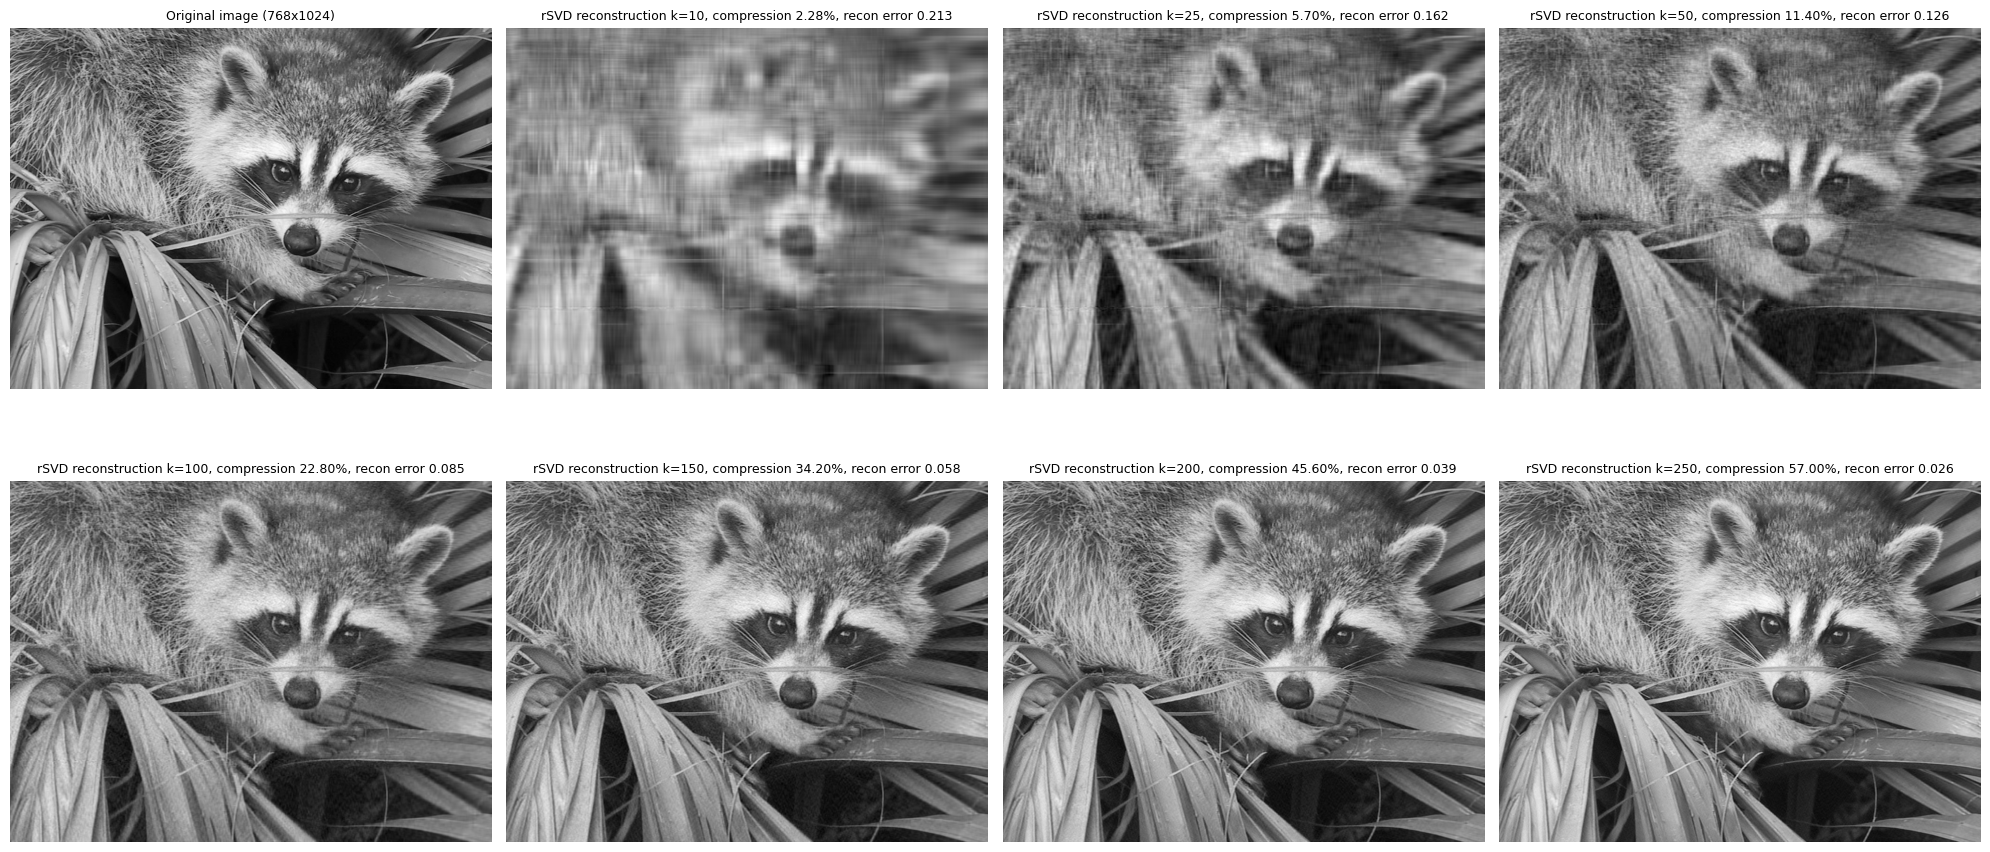

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import face  # built-in raccoon image

# 1. Prepare data: one grayscale image
img = face(gray=True)
print(f"Original image shape: {img.shape}")

# 2. rSVD function (reuse previous implementation)
def rsvd(A, k, q=2, oversample=10):
    m, n = A.shape
    l = k + oversample
    Omega = np.random.normal(size=(n, l))
    Y = A @ Omega
    for _ in range(q):
        Y = A @ (A.T @ Y)
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ u_tilde
    return U[:, :k], S[:k], Vt[:k, :]

# 3. Run rSVD for compression
# iterate through k = 10, 50, 100 to see different compression levels
img_reconstructeds = []
error_list = []
for k in [10, 25,  50,  100, 150, 200, 250]:
    U, S, Vt = rsvd(img, k=k, q=2)
    img_reconstructed = U @ np.diag(S) @ Vt
    img_reconstructeds.append((k, img_reconstructed))
    error = np.linalg.norm(img - img_reconstructed) / np.linalg.norm(img)
    error_list.append(error)

# 4. Plot comparison
# plot 2 x 4 grid: original and recons
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.title("Original image (768x1024)", fontsize=9)
plt.imshow(img, cmap='gray')
plt.axis('off') 

for i, (k, img_reconstructed) in enumerate(img_reconstructeds):
    plt.subplot(2, 4, i + 2)
    plt.title(f"rSVD reconstruction k={k}, compression {(k*(768+1024+1))/(768*1024):.2%}, recon error {error_list[i]:.3f}", fontsize=9)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


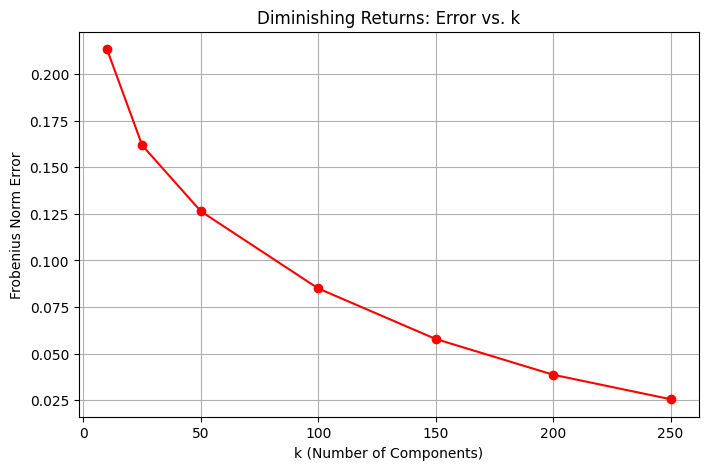

In [31]:
import matplotlib.pyplot as plt

k_values = [10, 25, 50, 100, 150, 200, 250]
errors = error_list

plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, 'o-', color='red', label='Reconstruction Error')


plt.title("Diminishing Returns: Error vs. k")
plt.xlabel("k (Number of Components)")
plt.ylabel("Frobenius Norm Error")
plt.grid(True)
plt.show()

## 如何确定k
2014 年 Gavish 和 Donoho 提出的“最佳硬阈值”公式。这是一个在含有噪声的矩阵中区分“信号”和“噪声”的最佳数学界限。简而言之，如果矩阵是正方形的 $(n \times n)$，最佳截断值大约是：$$\tau \approx 2.858 \cdot \text{median}(\text{所有奇异值})$$凡是小于这个 $\tau$ 的奇异值，都被视为噪声，直接扔掉。

问题是：如果我们需要计算所有的奇异值才能算出中位数，那我们实际上已经做了全量 SVD，这时候再用 rSVD 就完全没意义了（因为全量 SVD 已经把时间耗光了）。

在实际工程（尤其是流式计算或自动化处理大规模数据）中，我们通常根本不去“猜” $k$。我们使用一种被称为 “自适应随机 SVD” (Adaptive Randomized SVD) 的策略。

**核心思想**：反客为主

工程上我们通常有一个明确的精度指标（比如：误差不能超过 1%），而不是一个明确的秩指标（比如：一定要前 100 个特征）。所以，实际工程中用来确定 $k$ 的最常用方法是：设定一个容差 $\epsilon$ (tolerance)，让算法自己一点一点增加 $k$，直到误差低于这个容差为止。

### 实际工程算法：分块增量法 (Block-wise Incremental Approach)
这个方法由 Halko, Martinsson 和 Tropp 在 2011 年的经典论文中提出，是现代科学计算库（如 MATLAB, SciPy）背后的实际逻辑。
1. 算法步骤
- 设定步长 (Block Size)：设定一个小的块大小 $b$（比如每次算 10 个或 20 个特征）。
- 设定容差 (Tol)：比如 $10^{-3}$ (即 0.1% 的误差)。
- 第一轮迭代：
    - 生成 $b$ 个随机向量，计算投影。
    - 关键一步：估算剩下的“残差”（Residual，即还没被捕获的信息量）。
    - 如果 残差 > 容差，说明 $k$ 不够。
- 第二轮迭代：
    - 增加 $b$ 个新的随机向量（现在的 $k$ 变成了 $2b$）。
    - 再次计算残差。
- 循环：直到 残差 < 容差，或者达到内存允许的最大 $k$ 为止。

2. 如何快速算残差？
“算残差不是要用 $A$ 减去近似矩阵吗？那岂不是每一步都要做巨大的减法？”并不需要！ 数学技巧是：我们可以仅通过新生成的随机向量在当前残差上的投影范数，来概率性地估算总残差。这意味着我们根本不需要真正构建重构矩阵，计算成本极低（几乎是免费的）。
3. scipy.linalg.interpolative.svd eps_or_k 当传浮点数时， 启用adpative svd 模式

Original image shape: (768, 1024)


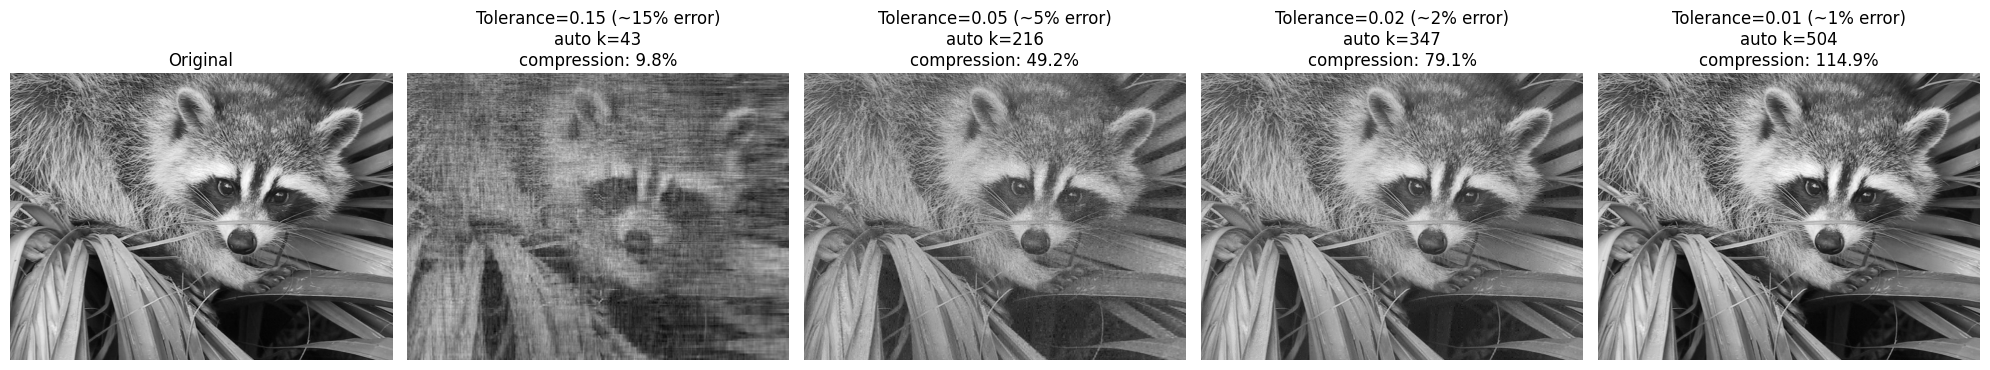

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import face
from scipy.linalg import interpolative

# 1. Prepare data: load raccoon image and convert to grayscale float
img = face(gray=True).astype(np.float64)
print(f"Original image shape: {img.shape}")

# =========================================================
# Core: use SciPy’s adaptive rSVD (interpolative.svd)
# =========================================================
def run_adaptive_rsvd(image, tolerance):
    """
    Wrap the call.
    tolerance: e.g., 0.1 means allow ~10% error.
    Note: interpolative.svd second arg:
      - int k -> fixed rank
      - float eps -> tolerance, auto-select rank
    """
    U, S, V = interpolative.svd(image, tolerance)
    k_determined = len(S)
    img_recon = U @ np.diag(S) @ V.T
    return img_recon, k_determined

# Two tolerances for comparison
tol_loose = 0.15   # looser (blurrier)
tol_strict = 0.05  # stricter (sharper)
tol_accurate = 0.02  # more accurate (sharpest)
tol_same = 0.01  # more accurate (sharpest)

# Run
img_loose, k_loose = run_adaptive_rsvd(img, tol_loose)
img_strict, k_strict = run_adaptive_rsvd(img, tol_strict)
img_accurate, k_accurate = run_adaptive_rsvd(img, tol_accurate)
img_same, k_same = run_adaptive_rsvd(img, tol_same)

# =========================================================
# Visualization
# =========================================================
plt.figure(figsize=(20, 6))

plt.subplot(1, 5, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 2)
compression_ratio_1 = (k_loose * (img.shape[0] + img.shape[1] + 1)) / (img.shape[0] * img.shape[1])
plt.title(f"Tolerance=0.15 (~15% error)\nauto k={k_loose}\ncompression: {compression_ratio_1:.1%}")
plt.imshow(img_loose, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 3)
compression_ratio_2 = (k_strict * (img.shape[0] + img.shape[1] + 1)) / (img.shape[0] * img.shape[1])
plt.title(f"Tolerance=0.05 (~5% error)\nauto k={k_strict}\ncompression: {compression_ratio_2:.1%}")
plt.imshow(img_strict, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 4)
compression_ratio_3 = (k_accurate * (img.shape[0] + img.shape[1] + 1)) / (img.shape[0] * img.shape[1])
plt.title(f"Tolerance=0.02 (~2% error)\nauto k={k_accurate}\ncompression: {compression_ratio_3:.1%}")
plt.imshow(img_accurate, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 5)
compression_ratio_4 = (k_same * (img.shape[0] + img.shape[1] + 1)) / (img.shape[0] * img.shape[1])
plt.title(f"Tolerance=0.01 (~1% error)\nauto k={k_same}\ncompression: {compression_ratio_4:.1%}")
plt.imshow(img_same, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## SVD 图片压缩率公式详解

这个公式用于计算 **压缩率 (Compression Ratio)**，即“压缩后还需要存储的数据量占原始数据量的比例”。

### 核心公式

$$
\text{Ratio} = \frac{\text{压缩后的数据量}}{\text{原始数据量}} = \frac{k \times (m + n + 1)}{m \times n}
$$

**参数定义：**
* $m = \text{img.shape}[0]$：图片高度（行数）
* $n = \text{img.shape}[1]$：图片宽度（列数）
* $k = k_{\text{accurate}}$：保留的特征数量（秩 Rank）

---

### 分母：原始数据量 ($m \times n$)

这是最直观的部分。一张图片本质上就是一个 $m \times n$ 的矩阵。要存储这张原始图片，需要记录矩阵里的**每一个像素点**。

* **总存储量** = $m \times n$ 个数值。

### 分子：压缩后的数据量 ($k \times (m + n + 1)$)

SVD 压缩的原理是不存储整个 $m \times n$ 矩阵，而是只存储分解后的三个小矩阵/向量：$U, \Sigma, V^T$。

回顾 SVD 近似公式：

$$
A \approx U_k \Sigma_k V_k^T
$$

我们需要存储这三部分的数据：

1.  **左奇异矩阵** $U_k$：
    * 形状是 $(m \times k)$
    * 需要存储 **$m \times k$** 个数值
2.  **右奇异矩阵** $V_k^T$ (或 $V_k$)：
    * 形状是 $(k \times n)$ (或 $n \times k$)
    * 需要存储 **$n \times k$** 个数值
3.  **奇异值** $\Sigma_k$：
    * 虽然 $\Sigma$ 理论上是 $(k \times k)$ 的矩阵，但它是**对角矩阵**（只有对角线上有值，其他都是 0）。
    * 所以我们不需要存 $k^2$ 个数，只需要存对角线上的 **$k$** 个奇异值即可。

**加起来的总和：**

$$
\text{总存储} = (m \times k) + (n \times k) + k
$$

**提取公因数 $k$：**

$$
= k \times (m + n + 1)
$$

这就是代码中 `k_accurate * (img.shape[0] + img.shape[1] + 1)` 的数学由来。

---

### 直观理解与陷阱

* **结果含义**：如果计算结果 = `0.15` (15%)，说明压缩后的数据大小只有原图的 15%，节省了 85% 的空间。

> **注意：越压越大？**
>
> 如果 $k$ 选得太大，这个比例可能会 **大于 1** (即 > 100%)。
>
> **举例说明：**
> * 假设 $m=1000, n=1000$
> * 如果选 $k=600$
> * **压缩后存储量** $\approx 600 \times (1000 + 1000) = 1,200,000$
> * **原图存储量** $= 1,000,000$
>
> **结论：** SVD 只适用于 **低秩近似 (Low Rank Approximation)**。只有当 $k$ 远小于 $m$ 和 $n$ 时，压缩才有意义。